In [ ]:
# Imports
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# Load dataset
df = pd.read_csv("GermanCredit.csv")
df['credit_risk'] = df['credit_risk'].astype(int)

# Define features and target
X = df.drop(columns=["credit_risk"])
y = df["credit_risk"]

# Identify feature types
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

# Train-test split (to evaluate generalization)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Class imbalance handling
scale = sum(y_train == 0) / sum(y_train == 1)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
)

# Full pipeline: preprocessing + model
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", xgb.XGBClassifier(
        eval_metric="logloss",
        scale_pos_weight=scale,
        random_state=42
    ))
])

# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['status', 'credit_history',
                                                   'purpose', 'savings',
                                                   'employment_duration',
                                                   'personal_status_sex',
                                                   'other_debtors', 'property',
                                                   'other_installment_plans',
                                                   'housing', 'job',
                                                   'telephone',
                                                   'foreign_work...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])


Model Evaluation on Test Set:

Accuracy: 0.7650

Confusion Matrix:
[[ 34  25]
 [ 22 119]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.58      0.59        59
           1       0.83      0.84      0.84       141

    accuracy                           0.77       200
   macro avg       0.72      0.71      0.71       200
weighted avg       0.76      0.77      0.76       200



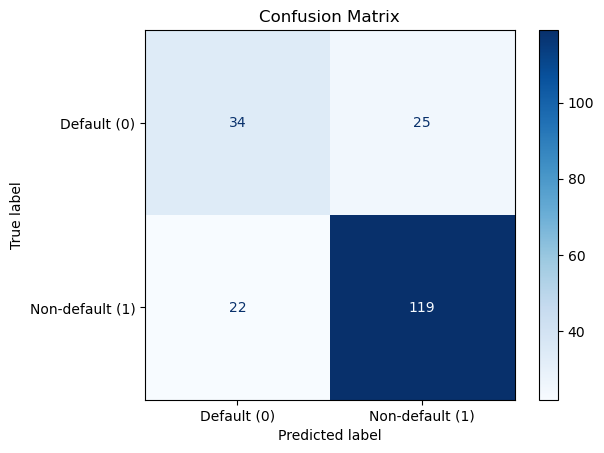


Cross-Validation Accuracy Scores: [0.725 0.73  0.76  0.755 0.78 ]
Average CV Accuracy: 0.7500 ± 0.0202


In [22]:
# Evaluate on test data
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"\nModel Evaluation on Test Set:")
print(f"\nAccuracy: {accuracy:.4f}")
print(f"\nConfusion Matrix:\n{conf_matrix}")
print(f"\nClassification Report:\n{class_report}")

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Default (0)", "Non-default (1)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Cross-validation (5-fold on full dataset)
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring="accuracy")
print("\nCross-Validation Accuracy Scores:", cv_scores)
print(f"Average CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

In [ ]:
# Export trained pipeline
joblib.dump(pipeline, "credit_default_pipeline.pkl")
print("pipeline saved as 'credit_default_pipeline.pkl'")

pipeline saved as 'credit_default_pipeline.pkl'


In [ ]:
pipeline = joblib.load("credit_default_pipeline.pkl")

# Sample prediction
sample = pd.DataFrame([{
    "status": "no_checking_account",
    "duration": 60,
    "credit_history": "critical_account_other_credits_existing",
    "purpose": "retraining",
    "amount": 60000,
    "savings": "unknown_no_savings_account",
    "employment_duration": "unemployed",
    "installment_rate": 6,
    "personal_status_sex": "male_single",
    "other_debtors": "guarantor",
    "present_residence": 1,
    "property": "unknown_no_property",
    "age": 18,
    "other_installment_plans": "bank",
    "housing": "rent",
    "number_credits": 5,
    "job": "unemployed_unskilled_non_resident",
    "people_liable": 6,
    "telephone": "no",
    "foreign_worker": "no"
}])

# Predict class and probability
pred_class = pipeline.predict(sample)[0]
pred_proba = pipeline.predict_proba(sample)[0][pred_class] 
proba = pipeline.predict_proba(sample)

# Human-readable label
label = "Likely to pay back" if pred_class == 0 else "Likely to default (not pay back)"

# Output
print(f"Prediction: {label}")
print("---------------------------------------------")
print(f"Probability of paying back (class 0): {proba[0][0] * 100:.2f}%")
print(f"Probability of default (class 1): {proba[0][1] * 100:.2f}%")

Prediction: Likely to default (not pay back)
---------------------------------------------
Probability of paying back (class 0): 40.19%
Probability of default (class 1): 59.81%
